### **Librerias**

In [ ]:
# --- instalar (solo si estás en Colab) ---
!pip -q install pandas numpy scikit-learn tldextract joblib matplotlib

# --- importar ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    precision_recall_curve, f1_score, recall_score
)

import tldextract
import joblib
import urllib.parse
import re, math
from pathlib import Path

# verificación rápida
print("OK pandas", pd.__version__, "| numpy", np.__version__)
print("OK scikit-learn")
print("OK tldextract ->", tldextract.extract("https://sub.ejemplo.com").suffix)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 1.6 MB/s eta 0:00:00
OK pandas 2.2.2 | numpy 2.0.2
OK scikit-learn
OK tldextract -> com


### **Montar drive**

In [ ]:
from google.colab import drive
from pathlib import Path

#Montar Drive
drive.mount('/content/drive')

#Definir ruta base del proyecto
BASE = Path('/content/drive/MyDrive/IA-1/DetectorPhishing')

#Verificar carpetas y listar CSVs en data/raw
raw_dir = BASE/'data'/'raw'
print('BASE existe?:', BASE.exists())
print('RAW existe?:', raw_dir.exists())

csvs = list(raw_dir.glob('*.csv')) if raw_dir.exists() else []
print('CSVs encontrados en data/raw:', [c.name for c in csvs])


Mounted at /content/drive
BASE existe?: True
RAW existe?: True
CSVs encontrados en data/raw: ['urlset.csv', 'malicious_phish.csv', 'uci-ml-phishing-dataset.csv']


### **Carga de Dataset**

In [ ]:
BASE = Path('/content/drive/MyDrive/IA-1/DetectorPhishing')
CSV = BASE/'data/raw/malicious_phish.csv'

#Cargar (robusto a encodings raros)
try:
    df_raw = pd.read_csv(CSV, dtype=str, low_memory=False, on_bad_lines='skip')
except UnicodeDecodeError:
    df_raw = pd.read_csv(CSV, dtype=str, low_memory=False, on_bad_lines='skip', encoding='latin1')

print('Shape crudo:', df_raw.shape)
print('Columnas:', list(df_raw.columns)[:10])
df_raw.head(3)


Shape crudo: (651191, 2)
Columnas: ['url', 'type']


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign


**Limpieza de los datos**

In [ ]:
# 2) Quedarnos con url/label y limpiar
df = df_raw.rename(columns={'type':'label', 'Type':'label', 'URL':'url', 'Url':'url'})
if not {'url','label'}.issubset({c.lower() for c in df.columns}):
    raise ValueError("No encuentro columnas url/label. Dime cómo se llaman para ajustarlo.")

# normalizar nombres exactos
rename_map = {c: c.lower() for c in df.columns}
df = df.rename(columns=rename_map)[['url','label']].dropna().drop_duplicates()
print('Tras limpieza básica:', df.shape)
df.head(3)


Tras limpieza básica: (641125, 2)


,url,label
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign


**Estandarizamos las etiquetas a binario**

In [ ]:
# 3) Estandarizar etiquetas a binario
LABEL_MAP = {
    'phishing':'phishing', 'malicious':'phishing', 'defacement':'phishing', 'malware':'phishing',
    'benign':'legit', 'legitimate':'legit', 'legit':'legit'
}
df['label'] = df['label'].str.lower().str.strip()
df = df[df['label'].isin(LABEL_MAP.keys())]
df['label'] = df['label'].map(LABEL_MAP)

print('Conteo por clase:')
print(df['label'].value_counts())


Conteo por clase:
label
legit       428080
phishing    213045
Name: count, dtype: int64


**Guardamos el dataset procesado**

In [ ]:
# 4) Guardar procesado
PROC = BASE/'data/processed/malicious_phish_processed.csv'
PROC.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(PROC, index=False)
print('Guardado en:', PROC)


Guardado en: /content/drive/MyDrive/IA-1/DetectorPhishing/data/processed/malicious_phish_processed.csv


### **Extracción de features numericas de las urls**

In [ ]:
URL_PREFIX_RE = re.compile(r'^(?:https?:\/\/)?(?:www\.)?', re.I)
IPV4_RE = re.compile(r"^((25[0-5]|2[0-4]\d|[01]?\d\d?)\.){3}(25[0-5]|2[0-4]\d|[01]?\d\d?)$")
SUS_WORDS = [
    'login','verify','account','bank','secure','update','free','bonus','gift','win','confirm',
    'paypal','apple','google','microsoft','office','support','service','limited','urgent'
]
COMMON_TLDS = set('com org net edu gov co io me us uk de fr es ru cn in br it nl au ca'.split())
SPECIALS = ['.', '-', '_', '%', '@', '?', '=', '&']

def shannon_entropy(s: str) -> float:
    if not s: return 0.0
    from collections import Counter
    cnt = Counter(s); n = len(s)
    return -sum((c/n) * math.log2(c/n) for c in cnt.values())

def split_url(u: str):
    u = str(u).strip().lower()
    cleaned = URL_PREFIX_RE.sub('', u)

    try:
        parsed = urllib.parse.urlparse('http://' + cleaned)
        host = parsed.netloc
        path = parsed.path or ''
        query = parsed.query or ''
    except ValueError:
        return '', '', ''

    return host, path, query


def featureize(url: str) -> dict:
    host, path, query = split_url(url)
    total = host + path + ('?' + query if query else '')
    ext = tldextract.extract(host)
    tld = (ext.suffix or '').split('.')[-1] if ext.suffix else ''
    return {
        'len_total': len(total),
        'len_host': len(host),
        'len_path': len(path),
        'len_query': len(query),
        'dots': total.count('.'),
        'hyphens': total.count('-'),
        'underscores': total.count('_'),
        'digits': sum(ch.isdigit() for ch in total),
        'percents': total.count('%'),
        'ats': total.count('@'),
        'qmarks': total.count('?'),
        'equals': total.count('='),
        'amps': total.count('&'),
        'slashes': total.count('/'),
        'path_depth': path.count('/'),
        'subdomains': max(0, host.count('.') - 1),
        'has_ip': 1 if IPV4_RE.match(host) else 0,
        'port_explicit': 1 if ':' in host else 0,
        'digit_ratio': (sum(ch.isdigit() for ch in total) / max(1, len(total))),
        'symbol_ratio': (sum(total.count(c) for c in SPECIALS) / max(1, len(total))),
        'tld_len': len(tld),
        'tld_rare': 0 if tld in COMMON_TLDS else 1,
        'entropy_host': shannon_entropy(host),
        'entropy_path': shannon_entropy(path),
        'sus_words': sum(w in total for w in SUS_WORDS),
    }

#aplicar al lote de 20k
df = pd.read_csv(BASE/'data/processed/malicious_phish_processed.csv', dtype=str, low_memory=False)
df_small = df.head(20000).copy()

rows = [featureize(u) for u in df_small['url'].astype(str)]
X_small = pd.DataFrame(rows)
y_small = (df_small['label'].str.lower() == 'phishing').astype(int)

print('Shapes -> X_small:', X_small.shape, ' y_small:', y_small.shape)
X_small.head(10)


Shapes -> X_small: (20000, 25)  y_small: (20000,)


,len_total,len_host,len_path,len_query,dots,hyphens,underscores,digits,percents,ats,...,subdomains,has_ip,port_explicit,digit_ratio,symbol_ratio,tld_len,tld_rare,entropy_host,entropy_path,sus_words
0,16,16,0,0,2,1,0,0,0,0,...,1,0,0,0.000000,0.187500,2,0,3.375000,0.000000,0
1,35,11,24,0,2,0,1,1,0,0,...,0,0,0,0.028571,0.085714,3,0,3.277613,3.855389,0
2,31,14,17,0,2,0,0,1,0,0,...,0,0,0,0.032258,0.064516,3,0,3.235926,3.292770,0
3,77,17,10,49,2,1,2,7,0,0,...,0,0,0,0.090909,0.168831,2,1,3.146286,3.121928,0
4,228,23,10,194,2,1,1,22,0,0,...,0,0,0,0.096491,0.043860,3,0,3.501398,3.121928,0
5,111,11,100,0,2,16,0,1,0,0,...,0,0,0,0.009009,0.162162,3,0,3.277613,4.059429,0
6,45,11,34,0,2,1,1,4,0,0,...,1,0,0,0.088889,0.088889,3,0,3.095795,4.094097,0
7,46,18,1,26,1,2,0,0,0,0,...,0,0,0,0.000000,0.108696,3,0,3.377444,-0.000000,0
8,33,18,15,0,1,1,0,0,0,0,...,0,0,0,0.000000,0.060606,3,0,3.461320,3.506891,0
9,45,12,33,0,1,4,0,5,0,0,...,0,0,0,0.111111,0.111111,3,0,3.084963,4.150159,0


### **Pruebas con los metodos vistos en clase**
Aqui queremos ver cual metodo se comporta de mejor manera para utilizarlo en el entrenamiento del modelo.

**Regresión lineal**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, recall_score, average_precision_score, make_scorer


# PR-AUC robusto: firma (estimator, X, y)
def pr_auc_scorer(estimator, X, y):
    if hasattr(estimator, "predict_proba"):
        scores = estimator.predict_proba(X)[:, 1]
    elif hasattr(estimator, "decision_function"):
        scores = estimator.decision_function(X)
    else:
        raise ValueError("El estimador no ofrece scores.")
    return average_precision_score(y, scores)

scoring = {
    "f1_phish": make_scorer(f1_score, pos_label=1),
    "recall_phish": make_scorer(recall_score, pos_label=1),
    "pr_auc": pr_auc_scorer,
}

logistic = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight="balanced", max_iter=1000)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
res = cross_validate(logistic, X_small, y_small, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise")

pd.DataFrame([{
    "model":"LogisticRegression",
    "f1_phish_mean": round(np.mean(res["test_f1_phish"]),4),
    "recall_phish_mean": round(np.mean(res["test_recall_phish"]),4),
    "pr_auc_mean": round(np.mean(res["test_pr_auc"]),4),
}])


,model,f1_phish_mean,recall_phish_mean,pr_auc_mean
0,LogisticRegression,0.6949,0.7414,0.741


**Arbol de decisión**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, recall_score, average_precision_score

def pr_auc_scorer(est, X, y):
    scores = est.predict_proba(X)[:,1]
    return average_precision_score(y, scores)

scoring = {
    "f1_phish": make_scorer(f1_score, pos_label=1),
    "recall_phish": make_scorer(recall_score, pos_label=1),
    "pr_auc": pr_auc_scorer,
}

tree = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
res = cross_validate(tree, X_small, y_small, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise")

pd.DataFrame([{
    "model":"DecisionTree",
    "f1_phish_mean": round(np.mean(res["test_f1_phish"]),4),
    "recall_phish_mean": round(np.mean(res["test_recall_phish"]),4),
    "pr_auc_mean": round(np.mean(res["test_pr_auc"]),4),
}])


,model,f1_phish_mean,recall_phish_mean,pr_auc_mean
0,DecisionTree,0.819,0.8169,0.7196


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, recall_score, average_precision_score, make_scorer

def pr_auc_scorer(est, X, y):
    scores = est.predict_proba(X)[:,1]
    return average_precision_score(y, scores)

scoring = {
    "f1_phish": make_scorer(f1_score, pos_label=1),
    "recall_phish": make_scorer(recall_score, pos_label=1),
    "pr_auc": pr_auc_scorer,
}

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
res = cross_validate(rf, X_small, y_small, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')

pd.DataFrame([{
    "model":"RandomForest",
    "f1_phish_mean": round(np.mean(res["test_f1_phish"]),4),
    "recall_phish_mean": round(np.mean(res["test_recall_phish"]),4),
    "pr_auc_mean": round(np.mean(res["test_pr_auc"]),4),
}])


,model,f1_phish_mean,recall_phish_mean,pr_auc_mean
0,RandomForest,0.8727,0.8203,0.9479


**SVM**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, recall_score, average_precision_score, make_scorer

def pr_auc_scorer(est, X, y):
    scores = est.decision_function(X)
    return average_precision_score(y, scores)

scoring = {
    "f1_phish": make_scorer(f1_score, pos_label=1),
    "recall_phish": make_scorer(recall_score, pos_label=1),
    "pr_auc": pr_auc_scorer,
}

linsvm = make_pipeline(
    StandardScaler(),
    LinearSVC(class_weight="balanced", dual=False, random_state=42)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
res = cross_validate(linsvm, X_small, y_small, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise")

pd.DataFrame([{
    "model":"SVM",
    "f1_phish_mean": round(np.mean(res["test_f1_phish"]),4),
    "recall_phish_mean": round(np.mean(res["test_recall_phish"]),4),
    "pr_auc_mean": round(np.mean(res["test_pr_auc"]),4),
}])


,model,f1_phish_mean,recall_phish_mean,pr_auc_mean
0,SVM,0.6948,0.7301,0.7415


**Gaussian NB**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, recall_score, average_precision_score, make_scorer

def pr_auc_scorer(est, X, y):
    scores = est.predict_proba(X)[:,1]
    return average_precision_score(y, scores)

scoring = {
    "f1_phish": make_scorer(f1_score, pos_label=1),
    "recall_phish": make_scorer(recall_score, pos_label=1),
    "pr_auc": pr_auc_scorer,
}

gnb = GaussianNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
res = cross_validate(gnb, X_small, y_small, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise")

pd.DataFrame([{
    "model":"GaussianNB",
    "f1_phish_mean": round(np.mean(res["test_f1_phish"]),4),
    "recall_phish_mean": round(np.mean(res["test_recall_phish"]),4),
    "pr_auc_mean": round(np.mean(res["test_pr_auc"]),4),
}])


,model,f1_phish_mean,recall_phish_mean,pr_auc_mean
0,GaussianNB,0.646,0.6176,0.7021


In [ ]:
model_results = pd.DataFrame(
    [
        {"model":"LogisticRegression", "f1_phish_mean": 0.6949, "recall_phish_mean": 0.7414, "pr_auc_mean": 0.741},
        {"model":"DecisionTree", "f1_phish_mean": 0.819, "recall_phish_mean": 0.8169, "pr_auc_mean": 0.7196},
        {"model":"RandomForest", "f1_phish_mean": 0.8727, "recall_phish_mean": 0.8203, "pr_auc_mean": 0.9479},
        {"model":"SVM", "f1_phish_mean": 0.6948, "recall_phish_mean": 0.7301, "pr_auc_mean": 0.7415},
        {"model":"GaussianNB", "f1_phish_mean": 0.646, "recall_phish_mean": 0.6176, "pr_auc_mean": 0.7021}
    ]
)

print("Resultados consolidados:")
display(model_results)

Resultados consolidados:


,model,f1_phish_mean,recall_phish_mean,pr_auc_mean
0,LogisticRegression,0.6949,0.7414,0.7410
1,DecisionTree,0.8190,0.8169,0.7196
2,RandomForest,0.8727,0.8203,0.9479
3,SVM,0.6948,0.7301,0.7415
4,GaussianNB,0.6460,0.6176,0.7021


### **Comparación de Modelos**
A continuación, se muestran gráficos comparativos de los diferentes modelos en base a sus métricas de rendimiento promedio.

/tmp/ipython-input-1314356483.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=metric, data=model_results, palette='viridis')
/tmp/ipython-input-1314356483.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=metric, data=model_results, palette='viridis')
/tmp/ipython-input-1314356483.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=metric, data=model_results, palette='viridis')


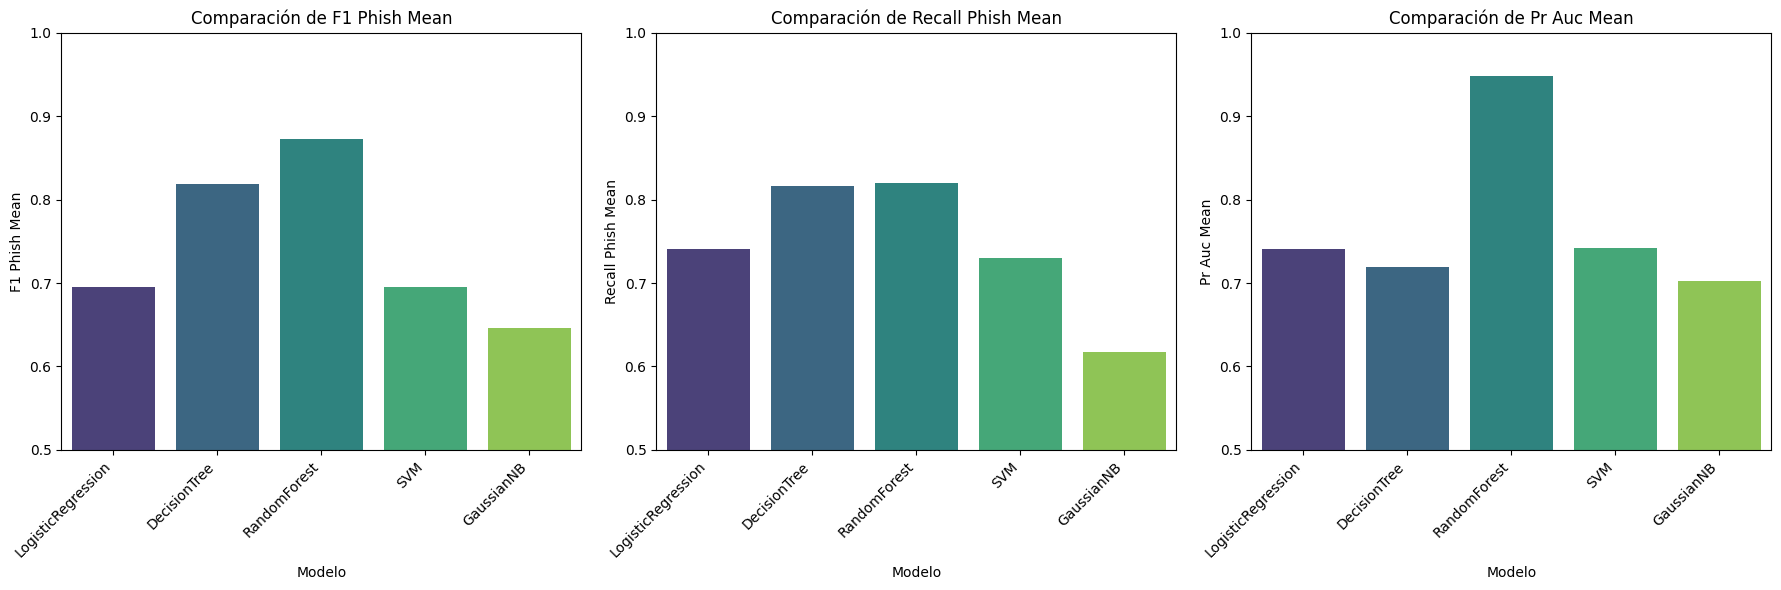

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['f1_phish_mean', 'recall_phish_mean', 'pr_auc_mean']

plt.figure(figsize=(18, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.barplot(x='model', y=metric, data=model_results, palette='viridis')
    plt.title(f'Comparación de {metric.replace("_", " ").title()}')
    plt.xlabel('Modelo')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

### **Entrenamiento y Evaluación del Modelo Random Forest**

In [ ]:
#Cargar el dataset procesado completo
PROC = BASE/'data/processed/malicious_phish_processed.csv'
df_full = pd.read_csv(PROC, dtype=str, low_memory=False)

print('Shape del dataset completo:', df_full.shape)
df_full.head(3)


Shape del dataset completo: (641125, 2)


,url,label
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,legit
2,bopsecrets.org/rexroth/cr/1.htm,legit


#### **Extracción de features para el dataset completo**

In [ ]:
#Aplicar featureize al dataset completo
print('Extrayendo características, esto puede tomar un tiempo...')
rows_full = [featureize(u) for u in df_full['url'].astype(str)]
X_full = pd.DataFrame(rows_full)
y_full = (df_full['label'].str.lower() == 'phishing').astype(int)

print('Shapes -> X_full:', X_full.shape, ' y_full:', y_full.shape)
X_full.head(3)

Extrayendo características, esto puede tomar un tiempo...
Shapes -> X_full: (641125, 25)  y_full: (641125,)


,len_total,len_host,len_path,len_query,dots,hyphens,underscores,digits,percents,ats,...,subdomains,has_ip,port_explicit,digit_ratio,symbol_ratio,tld_len,tld_rare,entropy_host,entropy_path,sus_words
0,16,16,0,0,2,1,0,0,0,0,...,1,0,0,0.000000,0.187500,2,0,3.375000,0.000000,0
1,35,11,24,0,2,0,1,1,0,0,...,0,0,0,0.028571,0.085714,3,0,3.277613,3.855389,0
2,31,14,17,0,2,0,0,1,0,0,...,0,0,0,0.032258,0.064516,3,0,3.235926,3.292770,0


#### **División de datos y entrenamiento del modelo Random Forest**

In [ ]:
#Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)
print('Shapes -> X_train:', X_train.shape, ' y_train:', y_train.shape)
print('Shapes -> X_test:', X_test.shape, ' y_test:', y_test.shape)

#4 wntrenar el modelo random forest
rf_final = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)
rf_final.fit(X_train, y_train)
print("Modelo entrenado con éxito.")

Shapes -> X_train: (512900, 25)  y_train: (512900,)
Shapes -> X_test: (128225, 25)  y_test: (128225,)
Modelo entrenado con éxito.


#### **Evaluación del modelo en el conjunto de prueba**

In [ ]:
#Evaluar el modelo
y_pred = rf_final.predict(X_test)
y_pred_proba = rf_final.predict_proba(X_test)[:, 1]

print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

print("\n--- Matriz de Confusión ---")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Average Precision Score (PR-AUC): {average_precision_score(y_test, y_pred_proba):.4f}")


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     85616
           1       0.88      0.83      0.85     42609

    accuracy                           0.91    128225
   macro avg       0.90      0.89      0.89    128225
weighted avg       0.91      0.91      0.91    128225


--- Matriz de Confusión ---
[[80915  4701]
 [ 7350 35259]]

ROC AUC Score: 0.9641
Average Precision Score (PR-AUC): 0.9417


Matriz de confusion

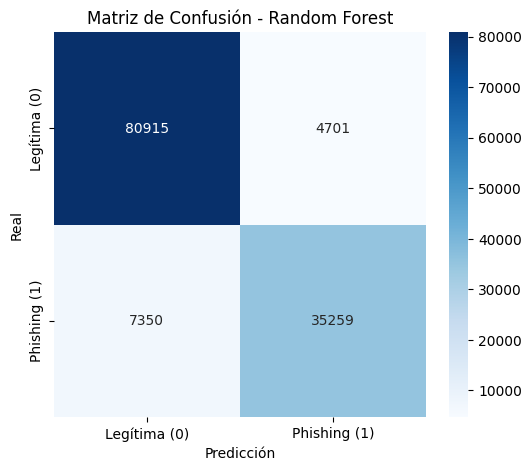

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = ["Legítima (0)", "Phishing (1)"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()


Curva ROC

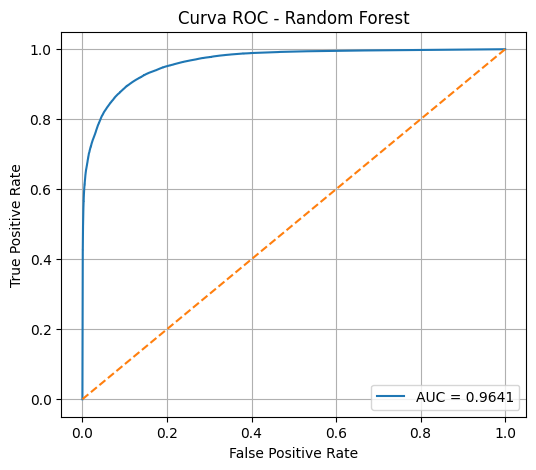

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

Curva Precision–Recall (PR Curve)

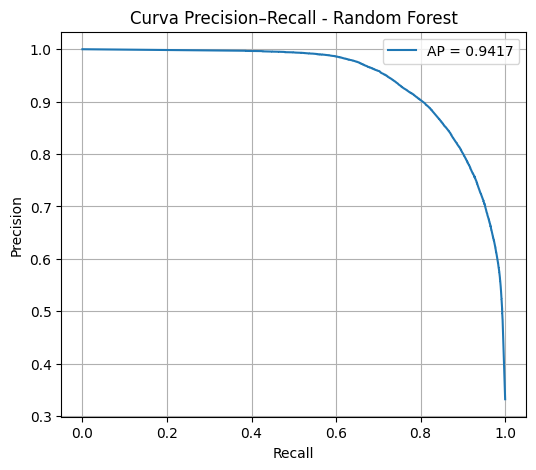

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - Random Forest")
plt.legend()
plt.grid(True)
plt.show()


Importancia de Features (Barplot)

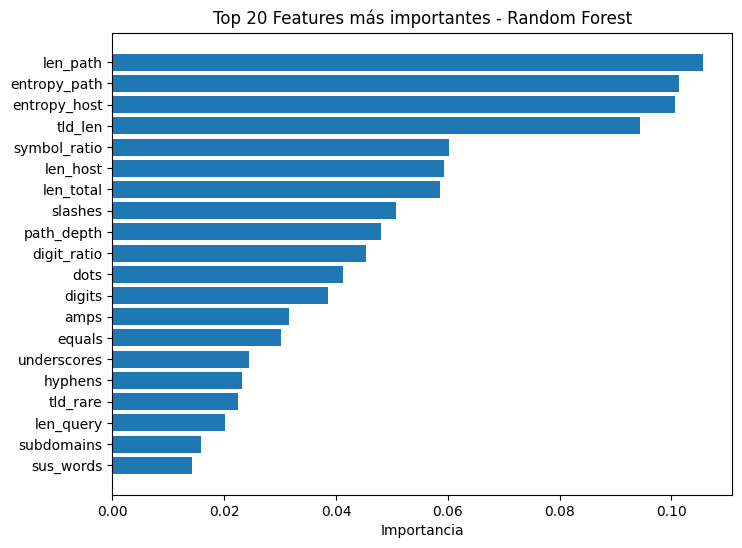

In [ ]:
import numpy as np

feature_importances = rf_final.feature_importances_
feature_names = X_train.columns

# Ordenar de mayor a menor
idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[idx][:20][::-1],
         feature_importances[idx][:20][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 Features más importantes - Random Forest")
plt.show()

#### **Guardar el modelo entrenado**

In [ ]:
#Guardar el modelo
MODEL_PATH = BASE/'models/random_forest_phishing_detector.joblib'
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(rf_final, MODEL_PATH)

print(f"Modelo Random Forest guardado en: {MODEL_PATH}")

Modelo Random Forest guardado en: /content/drive/MyDrive/IA-1/DetectorPhishing/models/random_forest_phishing_detector.joblib


**Pruebas unitarias**

In [ ]:
import joblib

MODEL_PATH = BASE / 'models/random_forest_phishing_detector.joblib'
model = joblib.load(MODEL_PATH)

print("Modelo cargado correctamente.")


Modelo cargado correctamente.


In [ ]:
import pandas as pd

def predecir_url(url: str):
    # Extraer características
    feats = featureize(url)

    # Convertir a DataFrame con una sola fila
    X = pd.DataFrame([feats])

    # Predicción (0=legítima, 1=phishing)
    pred = model.predict(X)[0]

    # Probabilidad de phishing
    prob = model.predict_proba(X)[0][1]

    return pred, prob


In [ ]:
url = "https://www.skqmmp8trk.com/2FGW889/6S9Z4JB/?sub1=20&sub2=854-71454&sub3=102-381385-20211"
pred, prob = predecir_url(url)

print("URL:", url)
print("Predicción:", "PHISHING" if pred == 1 else "Legítima")
print("Probabilidad:", prob)


URL: https://www.skqmmp8trk.com/2FGW889/6S9Z4JB/?sub1=20&sub2=854-71454&sub3=102-381385-20211
Predicción: Legítima
Probabilidad: 0.2633333333333333
